In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence, List
from langchain_core.messages import BaseMessage
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import glob
from pathlib import Path

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY", "")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")

In [2]:
# Ensure required modules are available when this cell is run standalone
import os
import glob

data_folder = 'data/structured_files'

csv_files = glob.glob(os.path.join(data_folder, '**/*.csv'), recursive=True)
excel_files = glob.glob(os.path.join(data_folder, '**/*.xlsx'), recursive=True) + \
              glob.glob(os.path.join(data_folder, '**/*.xls'), recursive=True)

print("Discovered files:")
print(f"CSV files ({len(csv_files)}): {csv_files}")
print(f"Excel files ({len(excel_files)}): {excel_files}")

Discovered files:
CSV files (2): ['data/structured_files\\IMDB-Movie-Data.csv', 'data/structured_files\\Products.csv']
Excel files (1): ['data/structured_files\\inventory.xlsx']


In [3]:
def detect_file_schema(df, filepath):
    columns = df.columns.tolist()
    sample_data = df.head(3).to_dict('records')
    
    schema_info = {
        'columns': columns,
        'num_columns': len(columns),
        'num_rows': len(df),
        'filepath': filepath,
        'sample_values': {}
    }
    
    for col in columns:
        non_null_values = df[col].dropna()
        if len(non_null_values) > 0:
            schema_info['sample_values'][col] = str(non_null_values.iloc[0])
    
    return schema_info

def process_csv_to_documents(filepath: str) -> tuple[List[Document], dict]:
    df = pd.read_csv(filepath)
    schema_info = detect_file_schema(df, filepath)
    documents = []
    columns = df.columns.tolist()
    
    for idx, row in df.iterrows():
        content_parts = []
        metadata = {
            'source': filepath,
            'row_index': idx,
            'file_type': 'csv',
            'filename': os.path.basename(filepath)
        }
        
        for col in columns:
            value = row[col]
            if pd.notna(value):
                content_parts.append(f"{col}: {value}")
        
        if content_parts:
            content = "\n".join(content_parts)
            doc = Document(
                page_content=content.strip(),
                metadata=metadata
            )
            documents.append(doc)
    
    return documents, schema_info

all_csv_documents = []
csv_schemas = []

for csv_path in csv_files:
    try:
        docs, schema = process_csv_to_documents(csv_path)
        all_csv_documents.extend(docs)
        csv_schemas.append(schema)
        print(f"Created {len(docs)} documents from {csv_path}")
        print(f"Schema: {schema['num_rows']} rows, {schema['num_columns']} columns")
        print(f"Columns: {schema['columns']}\n")
    except Exception as e:
        print(f"Error processing {csv_path}: {str(e)}\n")

print(f"Total CSV documents: {len(all_csv_documents)}")
if all_csv_documents:
    print(f"\nSample document:\n{all_csv_documents[0].page_content[:300]}")

Created 1000 documents from data/structured_files\IMDB-Movie-Data.csv
Schema: 1000 rows, 12 columns
Columns: ['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore']

Created 5 documents from data/structured_files\Products.csv
Schema: 5 rows, 5 columns
Columns: ['Product', 'Category', 'Price', 'Stock', 'Description']

Total CSV documents: 1005

Sample document:
Rank: 1
Title: Guardians of the Galaxy
Genre: Action,Adventure,Sci-Fi
Description: A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.
Director: James Gunn
Actors: Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana
Year: 2


In [4]:
def process_excel_to_documents(filepath: str) -> tuple[List[Document], dict]:
    documents = []
    all_schemas = []
    excel_file = pd.ExcelFile(filepath)
    
    for sheet_name in excel_file.sheet_names:
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        schema_info = detect_file_schema(df, f"{filepath}#{sheet_name}")
        schema_info['sheet_name'] = sheet_name
        all_schemas.append(schema_info)
        
        columns = df.columns.tolist()
        
        for idx, row in df.iterrows():
            content_parts = [f"Sheet: {sheet_name}"]
            metadata = {
                'source': filepath,
                'sheet_name': sheet_name,
                'row_index': idx,
                'file_type': 'excel',
                'filename': os.path.basename(filepath)
            }
            
            for col in columns:
                value = row[col]
                if pd.notna(value):
                    content_parts.append(f"{col}: {value}")
            
            if len(content_parts) > 1:
                content = "\n".join(content_parts)
                doc = Document(
                    page_content=content.strip(),
                    metadata=metadata
                )
                documents.append(doc)
    
    return documents, all_schemas

all_excel_documents = []
excel_schemas = []

for excel_path in excel_files:
    try:
        docs, schemas = process_excel_to_documents(excel_path)
        all_excel_documents.extend(docs)
        excel_schemas.extend(schemas)
        print(f"Created {len(docs)} documents from {excel_path}")
        for schema in schemas:
            print(f"Sheet: {schema.get('sheet_name', 'N/A')}, {schema['num_rows']} rows, {schema['num_columns']} columns")
            print(f"Columns: {schema['columns']}\n")
    except Exception as e:
        print(f"Error processing {excel_path}: {str(e)}\n")

print(f"Total Excel documents: {len(all_excel_documents)}")

Created 7 documents from data/structured_files\inventory.xlsx
Sheet: Products, 5 rows, 5 columns
Columns: ['Product', 'Category', 'Price', 'Stock', 'Description']

Sheet: Summary, 2 rows, 3 columns
Columns: ['Category', 'Total_Items', 'Total_Value']

Total Excel documents: 7


In [5]:
all_documents = all_csv_documents + all_excel_documents
all_schemas = csv_schemas + excel_schemas

print(f"Total documents: {len(all_documents)}")
print(f"CSV documents: {len(all_csv_documents)}")
print(f"Excel documents: {len(all_excel_documents)}")
print(f"Total schemas detected: {len(all_schemas)}")

Total documents: 1012
CSV documents: 1005
Excel documents: 7
Total schemas detected: 4


In [6]:
schema_summary = "Database contains the following data sources:\n\n"
for schema in all_schemas:
    source_name = schema.get('sheet_name', os.path.basename(schema['filepath']))
    schema_summary += f"Source: {source_name}\n"
    schema_summary += f"Columns: {', '.join(schema['columns'])}\n"
    schema_summary += f"Total records: {schema['num_rows']}\n\n"

print("Schema Summary:")
print(schema_summary)

Schema Summary:
Database contains the following data sources:

Source: IMDB-Movie-Data.csv
Columns: Rank, Title, Genre, Description, Director, Actors, Year, Runtime (Minutes), Rating, Votes, Revenue (Millions), Metascore
Total records: 1000

Source: Products.csv
Columns: Product, Category, Price, Stock, Description
Total records: 5

Source: Products
Columns: Product, Category, Price, Stock, Description
Total records: 5

Source: Summary
Columns: Category, Total_Items, Total_Value
Total records: 2




In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = FAISS.from_documents(
    documents=all_documents,
    embedding=embeddings
)

print("\nVector store created successfully")
print(f"Number of vectors: {vectorstore.index.ntotal}")


Vector store created successfully
Number of vectors: 1012


In [8]:
import hashlib
import time

folder_hash = hashlib.md5(data_folder.encode()).hexdigest()[:8]
timestamp = int(time.time())
vectorstore_name = f"vectorstore_{folder_hash}_{timestamp}"

vectorstore.save_local(vectorstore_name)
print(f"\nVector store saved to disk at '{vectorstore_name}'")


Vector store saved to disk at 'vectorstore_0417ffdb_1761549369'


In [9]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 7}
)

print("\nRetriever configured")


Retriever configured


In [10]:
class QueryInput(BaseModel):
    query: str = Field(description="The search query to find relevant information from the database")

@tool(args_schema=QueryInput)

def query_vector_database(query: str) -> str:
    """Search the movie and product database for relevant information"""
    retrieved_docs = retriever.invoke(query)
    context = "\n\n---\n\n".join([doc.page_content for doc in retrieved_docs])
    return context

print("\nTool created")


Tool created


In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [12]:
def agent(state: AgentState):
    print("---CALL AGENT---")
    messages = state["messages"]
    
    user_query = messages[0].content
    print(f"Retrieving context for: {user_query}")
    
    tool_result = query_vector_database.invoke({"query": user_query})
    
    tool_msg = ToolMessage(
        content=tool_result,
        tool_call_id="retrieval_call"
    )
    
    return {"messages": [tool_msg]}

In [13]:
def responder(state: AgentState):
    print("---GENERATE RESPONSE---")
    messages = state["messages"]
    
    tool_message = messages[-1]
    retrieved_context = tool_message.content
    
    question = messages[0].content
    
    system_prompt = f"""You are a helpful assistant with access to a structured database.

Database Schema Information:
{schema_summary}

Use the retrieved information to answer the user's question accurately and clearly.
The data fields shown above indicate what type of information is available in the database.
Provide specific details like names, numbers, and facts from the retrieved data.
If the information is not available in the retrieved data, say so clearly."""
    
    llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)
    
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Context: {retrieved_context}\n\nQuestion: {question}")
    ])
    
    return {"messages": [response]}

In [14]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
workflow.add_node("responder", responder)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "responder")
workflow.add_edge("responder", END)

graph = workflow.compile()

print("\nWorkflow graph compiled successfully")


Workflow graph compiled successfully


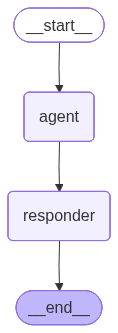

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available")

In [16]:
query1 = "What data sources are available in the database?"
response = graph.invoke({"messages": [HumanMessage(content=query1)]})
print(f"Query: {query1}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: What data sources are available in the database?
---GENERATE RESPONSE---
Query: What data sources are available in the database?

Answer: The database contains the following data sources:

1. **IMDB-Movie-Data.csv** – movie information (rank, title, genre, description, director, actors, year, runtime, rating, votes, revenue, metascore).  
2. **Products.csv** – product listings (product name, category, price, stock, description).  
3. **Products** – another view/table of product listings (same columns as the CSV).  
4. **Summary** – summary data by category (total items, total value).


In [17]:
query2 = "Show me the top entries by rating or value"
response = graph.invoke({"messages": [HumanMessage(content=query2)]})
print(f"\nQuery: {query2}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: Show me the top entries by rating or value
---GENERATE RESPONSE---

Query: Show me the top entries by rating or value

Answer: **Top entries by rating (movies)**  

| Rank | Title | Rating | Year | Revenue (Millions) |
|------|-------------------------------|--------|------|-------------------|
| 51   | *Star Wars: Episode VII – The Force Awakens* | **8.1** | 2015 | 936.63 |
| 519  | *The Hobbit: The Desolation of Smaug* | **7.9** | 2013 | 258.36 |
| 320  | *Fast Five* | **7.3** | 2011 | 209.81 |
| 79   | *Pirates of the Caribbean: Dead Man’s Chest* | **7.3** | 2006 | 423.03 |
| 942  | *The Twilight Saga: Eclipse* | **4.9** | 2010 | 300.52 |

*The list is sorted from the highest to the lowest rating. When ratings are tied (e.g., 7.3), the movies are shown in the order they appear in the data.*

---

**Top entries by value (revenue)**  

| Rank | Title | Revenue (Millions) | Rating |
|------|-------------------------------|-------------------|---

In [18]:
query4 = "Summarize the data from 2016"
response = graph.invoke({"messages": [HumanMessage(content=query4)]})
print(f"\nQuery: {query4}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: Summarize the data from 2016
---GENERATE RESPONSE---

Query: Summarize the data from 2016

Answer: **2016 Movie Data Summary**

| # | Title | Genre(s) | Director | Runtime (min) | Rating (IMDb) | Metascore | Revenue (M $) | Votes |
|---|-------|----------|----------|---------------|---------------|-----------|---------------|-------|
| 1 | Batman v Superman: Dawn of Justice | Action, Adventure, Sci‑Fi | Zack Snyder | 151 | 6.7 | 44 | 330.25 | 472,307 |
| 2 | Snowden | Biography, Drama, Thriller | Oliver Stone | 134 | 7.3 | 58 | 21.48 | 79,855 |
| 3 | Hidden Figures | Biography, Drama, History | Theodore Melfi | 127 | 7.8 | 74 | 169.27 | 93,103 |
| 4 | The Secret Life of Pets | Animation, Adventure, Comedy | Chris Renaud | 87 | 6.6 | 61 | 368.31 | 120,259 |
| 5 | The Purge: Election Year | Action, Horror, Sci‑Fi | James DeMonaco | 109 | 6.0 | 55 | 79.00 | 54,216 |

### Aggregate Statistics (all five 2016 movies)

| Metric | Value |
|--------|----

In [22]:
query5 = "List all movies in the Sci-Fi genre, including their year and runtime."
response = graph.invoke({"messages": [HumanMessage(content=query5)]})
print(f"\nQuery: {query5}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: List all movies in the Sci-Fi genre, including their year and runtime.
---GENERATE RESPONSE---

Query: List all movies in the Sci-Fi genre, including their year and runtime.

Answer: **Movies that include “Sci‑Fi” in their genre**

| Title | Year | Runtime (Minutes) |
|-------|------|-------------------|
| Star Trek Beyond | 2016 | 122 |
| Star Trek (2009) | 2009 | 127 |
| Cloverfield | 2008 | 85 |
| Rogue One | 2016 | 133 |
| Riddick | 2013 | 119 |
| Interstellar | 2014 | 169 |
| The Survivalist | 2015 | 104 |

All of the movies listed above have “Sci‑Fi” as part of their genre, and their year of release and runtime are taken directly from the provided data.


In [ ]:
"List all movies in the Sci-Fi genre, including their year and runtime."